# Code Details Report


1.Preparing Data folders

Note : May get a warning in the jupter notebook but you can ignore the warning

In [1]:
#Prepare dataset for one folder
import os
import pandas as pd
from PIL import Image

os.chdir('/Users/ars/AI/project')
os.chdir(os.path.join(os.getcwd(),'Data'))
print(os.getcwd())

fl = os.listdir(os.getcwd())
#fl.remove('.DS_Store')

for dirName in fl:
    path='/Users/ars/AI/project/Data/'+dirName+'/img/'
    list1=os.listdir(path)
    list1.sort()
    for img in list1:
        dst= path+dirName[0:len(dirName)-2]+img[-10:]
        src= path+img
        #print(src,dst)
        os.rename(src,dst)

df =pd.DataFrame(columns = ['label','x','y','width','height','img_name'])

#Combining dataset
for i in range(len(fl)):
    #Label
    label = fl[i]
    
    #Bounding Box
    bbox = pd.read_csv(os.getcwd()+'/'+label+'/groundtruth.txt', sep=",", header=None)
    bbox.columns = ['x','y','width','height']
    
    #Images
    img = os.listdir(os.path.join(os.getcwd(),label,'img'))
    img.sort()
    
    #Datset for the folder
    train = pd.DataFrame(columns = ['label','x','y','width','height'])
    train["label"] = pd.Series([label[0:len(fl[i])-2]]*bbox.shape[0])
    
    train.iloc[:,1:5] = bbox[:]
    #print(train.shape)
    img_folder = str(os.path.join(os.getcwd(),label,'img')) + '/'
    
    train["img_name"] = img
    
    #Normalizing data according to image size
    im = Image.open(os.path.join(os.getcwd(),label,'img',img[0]))
    width, height = im.size
    
    train['x'] = train['x']/width
    train['y'] = train['y']/height
    train['width'] = train['width']/width
    train['height'] = train['width']/height

    #Combining dataset
    df = df.append(train)
    
fl.sort()

label_names = {}
for i in range(len(fl)):
    label_names[str(fl[i][0:len(fl[i])-2])] = i

print(label_names)
df_new = df[:]
df_new["label"].replace(label_names, inplace =True)

print(df_new.iloc[0][5].split('.')[0]+'.txt')

txt_dir='/Users/ars/AI/project/text/'

os.chdir(txt_dir)

for j in range(len(df_new)):
    with open (df_new.iloc[j][5].split('.')[0]+'.txt','w') as f:
        for i in range(0,5):
            f.write("%s" % df.iloc[j][i]+" ")


/Users/ars/AI/project/Data


ValueError: Length of values does not match length of index

2. Split Training and testing data

This will split the images in the path into snowman_test.txt and snowman_train.txt

In [3]:
import random
import os
import subprocess
import sys

imagesFolder='/Users/ars/AI/project/JPEGImages'
def split_data_set(image_dir):

    f_val = open("snowman_test.txt", 'w')
    f_train = open("snowman_train.txt", 'w')
    
    path, dirs, files = next(os.walk(image_dir))
    data_size = len(files)

    ind = 0
    data_test_size = int(0.1 * data_size)
    test_array = random.sample(range(data_size), k=data_test_size)
    
    for f in os.listdir(image_dir):
        if(f.split(".")[1] == "jpg"):
            ind += 1
            
            if ind in test_array:
                f_val.write(image_dir+'/'+f+'\n')
            else:
                f_train.write(image_dir+'/'+f+'\n')


split_data_set(imagesFolder)
print('Done splitting data into test and train')

Done splitting data into test and train


4. Getting all the annotations of all images in the data set this includes all the annotations for 20 videos in each category

In [4]:
import glob2
import pandas as pd

from pathlib import Path

path = Path(r'/Users/ars/AI/project/Data')
# txt_files_only_subdirs = path.glob('*/nlp.txt')
txt_files_all_recursively = path.rglob('nlp*.txt') # including the current dir
#category = txt_files_all_recursively.split('/')
#print(category)

for file in txt_files_all_recursively:
    category = str(file).split('/')
    #print(category[5])
    contents = open(str(file),"r") 
    print(category[5][:-2]," : ",contents.read())


Da  :  white airplane landing on ground


5. Below is the code is plot training loss

Retrieving data and plotting training loss graph...
Done! Plot saved as training_loss_plot.png


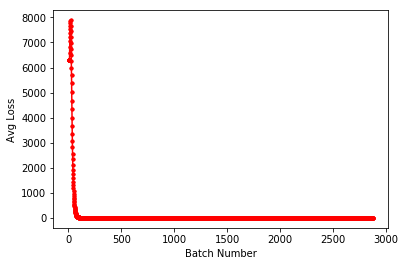

In [5]:
import sys
import matplotlib.pyplot as plt

lines = []
logFilePath='/Users/ars/AI/project/training.log'
for line in open(logFilePath):
    if "avg" in line:
        lines.append(line)

iterations = []
avg_loss = []

print('Retrieving data and plotting training loss graph...')
for i in range(len(lines)):
    lineParts = lines[i].split(',')
    iterations.append(int(lineParts[0].split(':')[0]))
    avg_loss.append(float(lineParts[1].split()[0]))

fig = plt.figure()
for i in range(0, len(lines)):
    plt.plot(iterations[i:i+2], avg_loss[i:i+2], 'r.-')

plt.xlabel('Batch Number')
plt.ylabel('Avg Loss')
fig.savefig('training_loss_plot.png', dpi=1000)
# display(fig)

print('Done! Plot saved as training_loss_plot.png')

6. Below is the code for Glove CNN

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 11 01:06:01 2019
"""
from keras.models import load_model
import os
os.getcwd()
import pandas as pd
import numpy as np 

os.chdir('/Users/ars/AI/ai/rnn')

annotation = open(os.path.join('/Users/ars/AI/ai/rnn','annotations.txt'))

df = pd.DataFrame(columns = ['text','labels'])

row_cnt = 0

#Create dictionary for labels
for i in annotation.readlines():

    x = i.split('.txt  :  ')
    
    label_text = x[0].split('/')
    label_text = label_text[len(label_text)-3]
    
    text = x[1]
    text = text[0:len(text)-1]
    
    df = df.append({'labels':label_text,'text':text}, ignore_index = True)
    
    row_cnt += 1

#Creating dictionary
label_set = list(set(df['labels']))
label_set.sort()

labels_index = {}

for i in range(len(label_set)):
    labels_index[label_set[i]] = i

#List of labels and texts
texts = []
labels = []

i = 0
for i in range(df.shape[0]):
    texts.append(df.text.iloc[i])
    labels.append(labels_index[df.labels.iloc[i]])

#Defining MAX_NB_length
#Defining MAX_SEQUENCE_LENGTH
unique_words = []
max_l = 0

for i in range(len(texts)):
    split_words = texts[i].split(' ')
    unique_words.extend(split_words)
    if(len(split_words) > max_l):
        max_l = len(split_words)


MAX_NB_WORDS = len(set(unique_words))
MAX_SEQUENCE_LENGTH = max_l



from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical 

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

VALIDATION_SPLIT = 0.25
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

## Preparing embedding layer

embeddings_index = {}
GLOVE_DIR = os.path.join(os.getcwd(),'glove.6B')
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM = 100
## Preparing embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


## Loading embedding matrix into embedding layer
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
        
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import Model
## Training Conv Net

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 2, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 2, activation='relu')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=20, batch_size=5)

#New prediction
new_text ='swimming in the water'
new_text = new_text.split(' ')
    
sequences = tokenizer.texts_to_sequences(new_text)

text_input = []
for i in range(len(sequences)):
    text_input.extend(sequences[i])

text_input = [text_input]
data = pad_sequences(text_input, maxlen=MAX_SEQUENCE_LENGTH)
print(data)

np.argmax(model.predict(data))

model.save('glove_cnn.h5')

Using TensorFlow backend.


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ars/AI/ai/rnn'

7. Below is the code for object detection once the training is done 

Note: This code is not capable of running in jupyter notebook. I included instructions on how to run it below

Command format : python3 object_detection_yolo.py --image=/home/santoshganti/learnopencv/YOLOv3-Training-Snowman-Detector/snowman_test_subset.txt

--image will take argument for the path to test file i.e., snowman_test.txt

In [ ]:
# This code is written at BigVision LLC. It is based on the OpenCV project. It is subject to the license terms in the LICENSE file found in this distribution and at http://opencv.org/license.html

# Usage example:  python3 object_detection_yolo.py --video=run.mp4
#                 python3 object_detection_yolo.py --image=bird.jpg

import cv2 as cv
import argparse
import sys
import numpy as np
import pandas as pd
import os.path
import pickle
from keras.models import load_model 
from keras.preprocessing.sequence import pad_sequences

# Initialize the parameters
#confThreshold = 0.5  #Confidence threshold
#nmsThreshold = 0.4  # Non-maximum suppression threshold

inpWidth = 416  #608     #Width of network's input image
inpHeight = 416 #608     #Height of network's input image

parser = argparse.ArgumentParser(description='Object Detection using YOLO in OPENCV')
parser.add_argument('--image', help='Path to image file.')
parser.add_argument('--video', help='Path to video file.')
args = parser.parse_args()
        
# Load names of classes
classesFile = "classes.names";

classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.

modelConfiguration = "/Users/ars/AI/learnopencv/YOLOv3-Training-Snowman-Detector/darknet-yolov3.cfg";
modelWeights = "/Users/ars/AI/learnopencv/YOLOv3-Training-Snowman-Detector/weights/darknet-yolov3_final.weights";

net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]
def draw_max(max_conf,my_det,my_classId,frame):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    classIds = []
    confidences = []
     #print("my_det ", my_det)
    if len(my_det) == 0:
        return [0, 0, 0, 0, 0]
    center_x = int(my_det[0] * frameWidth)
    center_y = int(my_det[1] * frameHeight)
    width = int(my_det[2] * frameWidth)
    height = int(my_det[3] * frameHeight)
    left = int(center_x - width / 2)
    top = int(center_y - height / 2)
    classIds.append(my_classId)
    confidences.append(float(max_conf))
    #boxes.append([left, top, width, height])
    
    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    #indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    drawPred(classIds[0], confidences[0], left, top, left + width, top + height)
    return[classIds[0], left, top, left + width, top + height]
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    #    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    cv.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv.FILLED)
    #cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs, object_class):
    #print ("outs :", outs)
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    max_conf = 0
    my_det = []
    for out in outs:
        #print("out.shape : ", out.shape)
        for detection in out:
            #if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            
            #if scores[classId]>confThreshold:
            confidence = scores[classId]
            #print(classId)
            #print("object class:",object_class)
            if (object_class==classId and confidence > max_conf):
                #print("confidence ", confidence)
                max_conf = confidence
                my_det = detection 
    return [max_conf,my_det,object_class,frame]
    

# Process inputs
winName = 'Deep learning object detection in OpenCV'
cv.namedWindow(winName, cv.WINDOW_NORMAL)
outputFile = "yolo_out_py.avi"

txtFile = open(args.image,'r')
txt = txtFile.readlines()

label_line = txt.pop(0)

new_text = label_line.split(' ')

with open('/Users/ars/AI/ai/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

sequences = tokenizer.texts_to_sequences(new_text)
text_input = []
for i in range(len(sequences)):
    text_input.extend(sequences[i])

text_input = [text_input]
MAX_SEQUENCE_LENGTH=16
data = pad_sequences(text_input, maxlen=MAX_SEQUENCE_LENGTH)

model = load_model('/Users/ars/AI/ai/glovecnn.h5')
object_class = np.argmax(model.predict(data))
print("object",object_class)
path=args.image[:-4]
list_main=[]
count=0
max_confidance=0
max_conf_list=[]
out_dir=''
counter=0
for img in txt:
    counter=counter+1
    img=img[:-1]
    image_link = str(img)
    image_name=image_link.split("/")[-1][:-4]
    
    if (args.image):
        # Open the image file
        if not os.path.isfile(image_link):
            print("Input image file ", image_link, " doesn't exist")
            sys.exit(1)
        cap = cv.VideoCapture(image_link)
        outputFile = path+"/"+image_name+'_yolo_out_py.jpg'
    elif (args.video):
        # Open the video file
        if not os.path.isfile(args.video):
            print("Input video file ", args.video, " doesn't exist")
            sys.exit(1)
        cap = cv.VideoCapture(args.video)
        outputFile = args.video[:-4]+'_yolo_out_py.avi'
    else:
        # Webcam input
        cap = cv.VideoCapture(0)

    # Get the video writer initialized to save the output video
    if (not args.image):
        vid_writer = cv.VideoWriter(outputFile, cv.VideoWriter_fourcc('M','J','P','G'), 30, (round(cap.get(cv.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))

    while cv.waitKey(1) < 0:

        # get frame from the video
        hasFrame, frame = cap.read()

        # Stop the program if reached end of video
        if not hasFrame:
            #print("Done processing !!!")
            #print("Output file is stored as ", outputFile)
            cv.waitKey(3000)
            break

        # Create a 4D blob from a frame.
        blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(getOutputsNames(net))

        # Remove the bounding boxes with low confidence
        
        list1 = postprocess(frame, outs,object_class)
        if(list1[0]>max_confidance):
            max_conf_list=list1
            out_dir=outputFile
            
        print("length",out_dir)
        if(counter==len(txt)):
            if(len(max_conf_list)!=0):
                print("in write ",out_dir)
                draw_max(max_conf_list[0],max_conf_list[1],max_conf_list[2],max_conf_list[3])
                t, _ = net.getPerfProfile()
                label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
                cv.imwrite(out_dir, max_conf_list[3].astype(np.uint8))
                cv.imshow(winName, max_conf_list[3])
            else:
                print("No Image with given discription")


8. Below is the code for getting iou scores

In [ ]:
import pandas as pd
import os

df = pd.read_csv('/Users/ars/AI/project/out.csv')

#print(df.columns.values)

df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.columns = ['image_path','class_label','left','up','right','down']


#df = pd.DataFrame(columns = ['image_path','class_label','left','up','right','down'])
ap = []

def find_match(contents, x):
    
    obj = contents.split(' ')
    
    obj_class = str(obj[0])
    obj_left = float(obj[1]) / 416.0
    obj_up = float(obj[2]) / 416.0
    obj_right = float(obj_up) + float(obj[3]) / 416.0
    obj_down = obj_left + float(obj[4]) / 416.0
    
    x_min = max(x[2], obj_left)
    x_max = min(x[2]+x[4], obj_right)
    y_min = max(x[3], obj_up)
    y_max = min(x[3]+x[5], obj_down)
    
    area = max(( x_max - x_min ) * ( y_max - y_min ) ,0)
    actual = x[4] * x[5]
    
    if(actual ==0):
        return 0
    score = area/actual
    

    match_class = ( int(x[1]) ==int( obj_class) )*1

    return(score*match_class)

for i in range(df.shape[0]):
    x = df.iloc[i]
    file_name = x[0].split("/")[-1][:-4]
    file_name = str(file_name) + '.txt'
    label_dir = '/Users/ars/AI/project/labels'
    
    f = open(os.path.join(label_dir, file_name))
    contents = f.read()
    
    area = find_match(contents, x)
    
    ap.append(area)

    
ser = pd.Series(ap)
print(ser.mean())
ser.to_csv('iou_scores.csv', index = False)